In [ ]:
!pip install -q kaggle


In [2]:
!mkdir ~/.kaggle

In [7]:
!cp kaggle.json ~/.kaggle

In [4]:
!cp ~/.kaggle -r /root/.kaggle

cp: -r not specified; omitting directory '/root/.kaggle'


In [8]:
!cd  /root/.kaggle/ && ls

kaggle.json


In [9]:
!kaggle datasets list -s'UCF Crime Dataset'

ref                                                          title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
odins0n/ucf-crime-dataset                                    UCF Crime Dataset                                  11GB  2021-11-11 13:16:24           5011        105  0.875            
minhajuddinmeraj/anomalydetectiondatasetucf                  Anomaly-Detection-Dataset-UCF                      38GB  2022-05-20 20:29:17           2386         25  0.625            
shashiprakash204/ucfcrimeminidataset                         ucf-crime-mini-dataset                            897MB  2021-10-29 10:28:55            164          5  0.375            
mission-ai/ucfdatasetforanomaly                              UCF-anomaly             

In [10]:
!kaggle datasets download -d odins0n/ucf-crime-dataset

100% 11.0G/11.0G [01:29<00:00, 179MB/s]
100% 11.0G/11.0G [01:29<00:00, 132MB/s]


In [11]:
!unzip /content/ucf-crime-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Train/Vandalism/Vandalism035_x264_230.png  
  inflating: Train/Vandalism/Vandalism035_x264_240.png  
  inflating: Train/Vandalism/Vandalism035_x264_250.png  
  inflating: Train/Vandalism/Vandalism035_x264_260.png  
  inflating: Train/Vandalism/Vandalism035_x264_270.png  
  inflating: Train/Vandalism/Vandalism035_x264_280.png  
  inflating: Train/Vandalism/Vandalism035_x264_290.png  
  inflating: Train/Vandalism/Vandalism035_x264_30.png  
  inflating: Train/Vandalism/Vandalism035_x264_300.png  
  inflating: Train/Vandalism/Vandalism035_x264_310.png  
  inflating: Train/Vandalism/Vandalism035_x264_320.png  
  inflating: Train/Vandalism/Vandalism035_x264_330.png  
  inflating: Train/Vandalism/Vandalism035_x264_340.png  
  inflating: Train/Vandalism/Vandalism035_x264_350.png  
  inflating: Train/Vandalism/Vandalism035_x264_360.png  
  inflating: Train/Vandalism/Vandalism035_x264_370.png  
  inflating: Train/Vandalism/Vandalism

In [12]:
train_dir = "/content/Train"
test_dir = "/content/Test"

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D, Conv2D,Flatten
from tensorflow.keras.models import Sequential 


In [32]:
train_dir = "/content/Train"
test_dir = "/content/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
BATCH_SIZE = 128
EPOCHS = 5
LR = 0.00003

In [33]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of crime categories : ",n)

Number of crime categories :  14


In [34]:
crimes={}
train=test=0
for clss in crime_types:
  num=len(os.listdir(os.path.join(train_dir,clss)))
  train+=num
  test+=len(os.listdir(os.path.join(test_dir,clss)))
  crimes[clss]=num

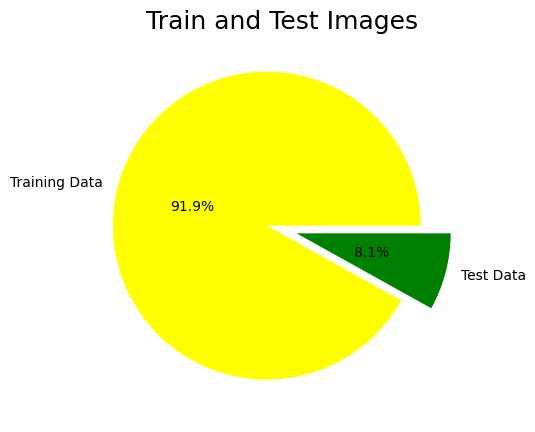

In [35]:
plt.figure(figsize=(8, 5))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5,colors=['yellow','green'])
plt.title("Train and Test Images", fontsize=18);

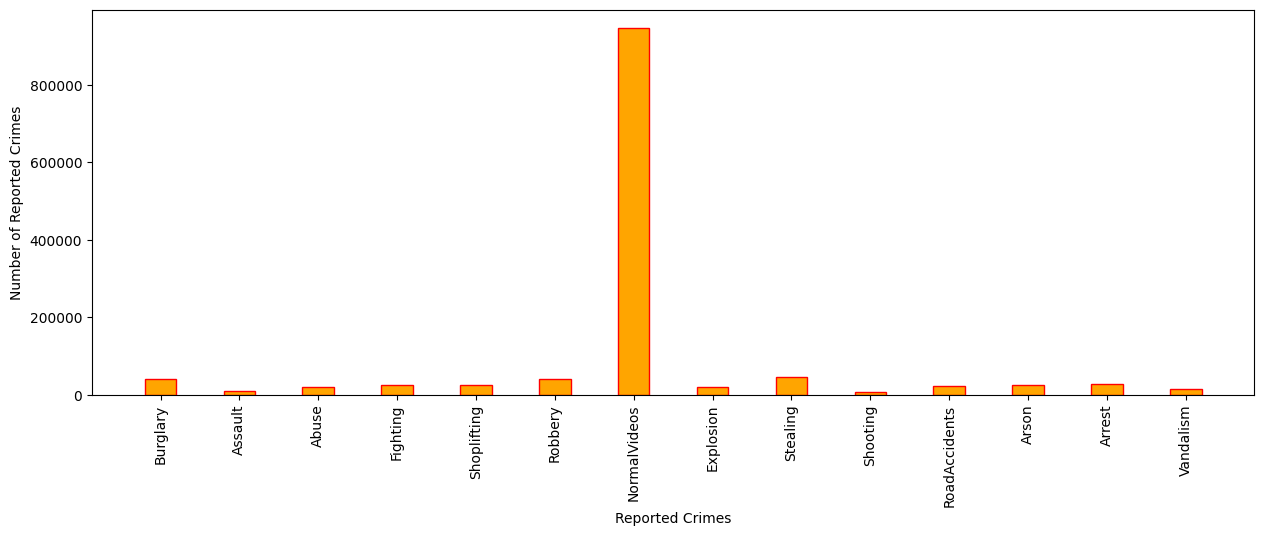

In [36]:
plt.figure(figsize=(15,5))

plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4,align="center",edgecolor=['red'],color=['orange'])
plt.xticks(rotation=90)

plt.xlabel("Reported Crimes")
plt.ylabel("Number of Reported Crimes") 
plt.show()


In [37]:
train_set=image_dataset_from_directory( 
    train_dir, 
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2, 
    subset="training",
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


In [39]:
val_set=image_dataset_from_directory( 
    train_dir, 
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2, 
    subset="validation",
)

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [38]:
test_set=image_dataset_from_directory( 
    test_dir, 
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=SEED,
)

Found 111308 files belonging to 14 classes.


In [40]:
def transfer_learning():

  base_model=DenseNet121(include_top=False, input_shape=(64,64,3), weights="imagenet")

  thr=149

  for layers in base_model.layers[:thr]: 
    layers.trainable=False
  for layers in base_model.layers[thr:]: 
    layers.trainable=False

  return base_model

In [49]:
def create_model():
  model=Sequential()

  base_model=transfer_learning() 
  model.add(base_model)

  model.add(GlobalAveragePooling2D())

  model.add(Dense (256, activation="relu")) 
  model.add(Dropout (0.2))

  model.add(Dense (512, activation="relu")) 
  model.add(Dropout (0.2))

  model.add(Dense (1024, activation="relu"))

  model.add(Dense (14, activation="softmax"))

  model.summary()
  return model


In [51]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_8 (Dense)             (None, 256)               262400    
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                      

In [52]:
model=create_model()

model.compile(optimizer="adam",
                loss='categorical_crossentropy',
                metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_12 (Dense)            (None, 256)               262400    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 512)               131584    
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                      

In [53]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

Epoch 1/5
7915/7915 [==============================] - 1567s 195ms/step - loss: 0.3419 - accuracy: 0.9060 - val_loss: 0.1182 - val_accuracy: 0.9663
Epoch 2/5
7915/7915 [==============================] - 1409s 178ms/step - loss: 0.1944 - accuracy: 0.9459 - val_loss: 0.0800 - val_accuracy: 0.9788
Epoch 3/5
7915/7915 [==============================] - 1408s 178ms/step - loss: 0.1677 - accuracy: 0.9542 - val_loss: 0.0697 - val_accuracy: 0.9808
Epoch 4/5
7915/7915 [==============================] - 1393s 176ms/step - loss: 0.1571 - accuracy: 0.9581 - val_loss: 0.0655 - val_accuracy: 0.9825
Epoch 5/5
7915/7915 [==============================] - 1422s 180ms/step - loss: 0.1472 - accuracy: 0.9613 - val_loss: 0.0593 - val_accuracy: 0.9848


In [54]:
model.save("crime.h5")


In [44]:
y_true = np.array([])
for x,y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis =-1)])

In [58]:
y_pred=model.predict(test_set)

870/870 [==============================] - 57s 62ms/step


In [ ]:
y_pred

array([[2.0995876e-02, 6.8679675e-02, 1.3205944e-01, ..., 1.1495518e-02,
        7.1920068e-03, 4.0614907e-02],
       [4.4894800e-02, 3.0490881e-02, 6.1819874e-02, ..., 1.5499873e-02,
        2.6593029e-02, 4.7555897e-02],
       [1.1505616e-02, 3.7555885e-02, 4.5355577e-03, ..., 9.3390954e-05,
        1.9057236e-03, 1.8652199e-02],
       ...,
       [2.1208542e-05, 1.2475036e-03, 6.5872053e-05, ..., 1.0228071e-03,
        3.4178895e-05, 2.8050580e-04],
       [2.7938389e-05, 5.6444609e-04, 7.8478995e-05, ..., 4.2531991e-04,
        1.7537403e-05, 2.2778491e-04],
       [9.0933776e-05, 2.2424912e-04, 3.9887142e-05, ..., 4.4670841e-04,
        9.5708683e-06, 1.0513914e-04]], dtype=float32)

In [61]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [71]:
from tensorflow.keras.preprocessing import image
img=image.load_img('/content/Test/Burglary/Burglary005_x264_0.png', target_size=(64,64))

x= image.img_to_array(img) # Converting image into array

x= np.expand_dims (x,axis=0) 
pred=np.argmax(model.predict(x)) # Predicting the higher probablity index

op=['Fighting', 'Arrest', 'Vandalism', 'Assault', 'Stealing', 'Arson', 'NormalVideos', 'Burglary', 'Explosion', 'Robbery', 'Abuse', 'Shooting', 'Shoplifting']
op[pred]

1/1 [==============================] - 0s 32ms/step


'Burglary'

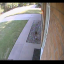

1/1 [==============================] - 2s 2s/step


'Burglary'

In [72]:
from PIL import Image

# Load the image
img = Image.open('/content/Test/Burglary/Burglary005_x264_0.png')

# Resize the image to a specific size
img = img.resize((64, 64))

# Display the image
img.show()
x= img # Converting image into array
x= np.expand_dims (x,axis=0) 
pred=np.argmax(model.predict(x)) # Predicting the higher probablity index

op=['Fighting', 'Arrest', 'Vandalism', 'Assault', 'Stealing', 'Arson', 'NormalVideos', 'Burglary', 'Explosion', 'Robbery', 'Abuse', 'Shooting', 'Shoplifting']
op[pred]

In [ ]:
!tar -zcvf crimevision.tgz crime.h5

crime.h5


In [ ]:
!pip install watson-machine-learning-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.9/538.9 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 68.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 971.7/971.7 kB 65.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.3 MB/s eta 0:00:00
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.13.0-py3-none-any.whl size=73917 sha256=1c28aa31f83078fa68943fb40af809a9a0317

In [ ]:
!pip install ibm_watson_machine_learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 18.1 MB/s eta 0:00:00


In [ ]:
from ibm_watson_machine_learning import APIClient

In [ ]:
wml_credentials={
 "url":"https://us-south.ml.cloud.ibm.com",
"apikey":"r7zZVO0QKGekRlDFQDIhiEkpwyfyoDUgeJGh1Hf8xyZA"
}

In [ ]:

client=APIClient(wml_credentials)

In [ ]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----------------  ------------------------
ID                                    NAME               CREATED
46536d93-0dfb-46b7-8de1-20a807c28b60  crimevisiondeploy  2023-05-20T07:29:32.983Z
------------------------------------  -----------------  ------------------------


,ID,NAME,CREATED
0,46536d93-0dfb-46b7-8de1-20a807c28b60,crimevisiondeploy,2023-05-20T07:29:32.983Z


In [ ]:
space_uid="46536d93-0dfb-46b7-8de1-20a807c28b60" 

In [ ]:
client.set.default_space(space_uid)

'SUCCESS'

In [ ]:
client.software_specifications.list(200)

-------------------------------  ------------------------------------  ----  ------------------  --------------------------
NAME                             ID                                    TYPE  STATE               REPLACEMENT
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base  unsupported         runtime-22.2-py3.10
autoai-ts_rt23.1-py3.10          01ce9391-1a79-5a33-94fb-2e134337f314  base  not_provided
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base  not_provided
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base  not_provided
tensorflow_rt23.1-py3.10         079a91e0-245f-5269-8926-3c20b28f37dc  base  not_provided
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base  unsupported         runtime-22.2-py3.10
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base  unsupported
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base  create-

,NAME,ID,TYPE,STATE,REPLACEMENT
0,default_py3.6,0062b8c9-8b7d-44a0-a9b9-46c416adcbd9,base,unsupported,runtime-22.2-py3.10
1,autoai-ts_rt23.1-py3.10,01ce9391-1a79-5a33-94fb-2e134337f314,base,not_provided,
2,kernel-spark3.2-scala2.12,020d69ce-7ac1-5e68-ac1a-31189867356a,base,not_provided,
3,pytorch-onnx_1.3-py3.7-edt,069ea134-3346-5748-b513-49120e15d288,base,not_provided,
4,tensorflow_rt23.1-py3.10,079a91e0-245f-5269-8926-3c20b28f37dc,base,not_provided,
...,...,...,...,...,...
103,runtime-22.2-r4.2,ec0a3d28-08f7-556c-9674-ca7c2dba30bd,base,supported,
104,tensorflow_rt22.2-py3.10,f65bd165-f057-55de-b5cb-f97cf2c0f393,base,supported,
105,do_20.1,f686cdd9-7904-5f9d-a732-01b0d6b10dc5,base,supported,
106,scikit-learn_0.19-py3.6,f963fa9d-4bb7-5652-9c5d-8d9289ef6ad9,base,unsupported,runtime-22.2-py3.10


In [ ]:
software_space_uid=client.software_specifications.get_uid_by_name('tensorflow_rt22.2-py3.10')

In [ ]:
model_details=client.repository.store_model(model='crimevision.tgz',meta_props={
client.repository.ModelMetaNames.NAME:"crimevision",
client.repository.ModelMetaNames.TYPE:'tensorflow_2.9',
client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_space_uid
})

In [ ]:
model_id=client.repository.get_model_id(model_details)

In [ ]:
model_id

'57f895c1-1c47-421b-b711-77ac8b5138d1'

In [ ]:
client.repository.download(model_id,'CrimeVision.tgz')

Successfully saved model content to file: 'CrimeVision.tgz'


'/content/CrimeVision.tgz'